In [1]:
# -*- coding: utf-8 -*-

## Map Generalization for Polygons using Autoencode-like strucutures
## Adatped based on Master Thesis of SERCAN CAKIR "ROAD NETWORK EXTRACTION USING CNN"
## Author: Yu Feng, yuzz.feng@gmail.com
## 1. Version Author: SERCAN CAKIR

## Changes:
## 1. Two conv layers were added before the first down convlusional layer
## 2. Output can be any size during the evaluation
## 3. Adapt the code to support more images as training examples
## 4. Dropouot may make the sharpe corners vanishing, we delete half of them, but we should used some
## 5. Splilt step for generate training and validation data
## 6. Prepare to update in github

import matplotlib
#matplotlib.use('Agg') # necessary for linux kernal
%matplotlib inline
import matplotlib.pyplot as plt

import os
import numpy as np
from numpy import random
np.random.seed(7)
import keras
from keras.models import Sequential
from keras.callbacks import History
from keras.layers.core import Dropout
#from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers import MaxPooling2D, Conv2DTranspose, BatchNormalization, Activation
from keras import backend as K

from keras.models import Model
from keras.layers import Input, Conv2D, Dropout, UpSampling2D, Activation, Concatenate

from osgeo import gdal
from sklearn.model_selection import train_test_split
from skimage.util.shape import view_as_windows

from data_helper import readImg, readImgInv, imagePatches, removeBlackImg, removeCorrespondence, check_and_create

from time import gmtime, strftime
timestr = strftime("%Y-%m-%d %H-%M-%S", gmtime())

scale = 15 #25

############ Path Setting ##############
#outPath = r"Prediction/"
outPath = r"../tmp_results/predictions/"
outPath = outPath + timestr + '_' + str(scale)+ "/"
check_and_create(outPath)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Models

## Prepare Training Data

In [2]:
# Order the image dimension acc. to TensorFlow (batc_hsize, rows, cols, channels)
K.set_image_dim_ordering('tf')

p_size_1 = 128 # Compared with 256, which larger may generate round corners
trainPath = r"../tmp_data/data_feng/geb" + str(scale) +  "/"

# save image patch arrays
x_train_sim = np.load(trainPath + "x_train_sim.npy")
y_train_sim = np.load(trainPath + "y_train_sim.npy")
x_test_sim = np.load(trainPath + "x_test_sim.npy")
y_test_sim = np.load(trainPath + "y_test_sim.npy")

Input Shape of the models (32289, 128, 128, 1)


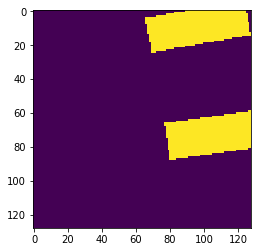

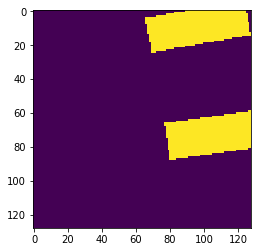

In [4]:
plt.figure()
plt.imshow(np.reshape(x_test_sim[2], (p_size_1,p_size_1)))
plt.figure()
plt.imshow(np.reshape(y_test_sim[2], (p_size_1,p_size_1)))

input_shape1 = (None, None, 1) #x_train_sim[0].shape
print('Input Shape of the models', x_train_sim.shape)
import keras
from keras import backend as K

from keras.models import Model
from keras.models import Sequential

from keras.layers.core import Dropout
from keras.layers import Input, Conv2D, Dropout, UpSampling2D, Activation, Concatenate, Add
from keras.layers import MaxPooling2D, Conv2DTranspose, BatchNormalization, Activation


In [17]:
import keras
from keras import backend as K

from keras.models import Model
from keras.models import Sequential

from keras.layers.core import Dropout
from keras.layers import Input, Conv2D, Dropout, UpSampling2D, Activation, Concatenate, Add
from keras.layers import MaxPooling2D, Conv2DTranspose, BatchNormalization, Activation

def res_block(x, nb_filters, strides):
    res_path = BatchNormalization()(x)
    res_path = Activation(activation='relu')(res_path)
    res_path = Conv2D(filters=nb_filters[0], kernel_size=(3, 3), padding='same', strides=strides[0])(res_path)
    res_path = BatchNormalization()(res_path)
    res_path = Activation(activation='relu')(res_path)
    res_path = Conv2D(filters=nb_filters[1], kernel_size=(3, 3), padding='same', strides=strides[1])(res_path)

    shortcut = Conv2D(nb_filters[1], kernel_size=(1, 1), strides=strides[0])(x)
    shortcut = BatchNormalization()(shortcut)

    res_path = Add()([shortcut, res_path])
    return res_path

def decoder(x, from_encoder):
    #main_path = UpSampling2D(size=(2, 2))(x)
    #main_path = Concatenate(axis=3)([main_path, from_encoder[2]])
    #main_path = res_block(main_path, [256, 256], [(1, 1), (1, 1)])

    #main_path = UpSampling2D(size=(2, 2))(main_path) #3x
    
    main_path = UpSampling2D(size=(2, 2))(x) #2x
    main_path = Concatenate(axis=3)([main_path, from_encoder[1]])
    main_path = res_block(main_path, [128, 128], [(1, 1), (1, 1)])

    main_path = UpSampling2D(size=(2, 2))(main_path)
    main_path = Concatenate(axis=3)([main_path, from_encoder[0]])
    main_path = res_block(main_path, [64, 64], [(1, 1), (1, 1)])

    return main_path

def encoder(x):
    to_decoder = []

    main_path = Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=(1, 1))(x)
    main_path = BatchNormalization()(main_path)
    main_path = Activation(activation='relu')(main_path)

    main_path = Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=(1, 1))(main_path)

    shortcut = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1))(x)
    shortcut = BatchNormalization()(shortcut)

    main_path = Add()([shortcut, main_path])
    # first branching to decoder
    to_decoder.append(main_path)

    main_path = res_block(main_path, [128, 128], [(2, 2), (1, 1)])
    to_decoder.append(main_path)

    #main_path = res_block(main_path, [256, 256], [(2, 2), (1, 1)])
    #to_decoder.append(main_path)

    return to_decoder


def build_res_unet(input_shape):
    inputs = Input(shape=input_shape)

    to_decoder = encoder(inputs)

    #path = res_block(to_decoder[2], [512, 512], [(2, 2), (1, 1)]) # 3x
    path = res_block(to_decoder[1], [512, 512], [(2, 2), (1, 1)]) # 2x

    path = decoder(path, from_encoder=to_decoder)

    path = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(path)

    return Model(input=inputs, output=path)



##### Building the CNN archıtecture with "Model" - skip connections were added
def create_model_residual(optimizer, input_shape, drop_rate = 0.1):

    model = build_res_unet(input_shape)
    model.compile(optimizer=optimizer,
                  loss = 'binary_crossentropy',
                  metrics=['acc'])
    
    return model

In [18]:
from kmodels import create_model_add_skips_2

opt1 = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
#opt1 = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

#model_ex1 = create_model(opt1, input_shape1)
#model_ex1 = create_model_batch(opt1, input_shape1) # Not good as the skip connection
#model_ex1 = create_model_add_skips(opt1, input_shape1)
#model_ex1 = create_model_add_skips_3(opt1, input_shape1) # Add max pool but not better

#model_ex1 = create_model_add_skips_2(opt1, input_shape1) # ISPRS TCIV
#model_ex1 = create_model_add_skips_linfnorm(opt1, input_shape1)

model_ex1 = create_model_residual(opt1, input_shape1) # Residual

model_ex1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, None, None, 6 640         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_35 (BatchNo (None, None, None, 6 256         conv2d_40[0][0]                  
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, None, None, 6 128         input_6[0][0]                    
__________________________________________________________________________________________________
activation

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:79: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [19]:
import itertools
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [20]:
data_gen_args = dict(rotation_range=180.)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1
BATCH_SIZE = 16
result_generator = zip(image_datagen.flow(x_train_sim, batch_size=BATCH_SIZE, seed=seed), 
                       mask_datagen.flow(y_train_sim, batch_size=BATCH_SIZE, seed=seed))

History1 = History()
hist1 = model_ex1.fit_generator(  result_generator,
                                  epochs = 100,
                                  steps_per_epoch=2000,
                                  verbose=1,
                                  shuffle=True,
                                  callbacks=[History1, 
                                             EarlyStopping(patience=5), 
                                             ReduceLROnPlateau(patience = 3, verbose = 0),
                                             ModelCheckpoint(outPath + "weights.hdf5", 
                                                             save_best_only = True, 
                                                             save_weights_only = False)],
                                  validation_data=(x_test_sim, y_test_sim))

Epoch 1/100
2000/2000 [==============================] - 438s 219ms/step - loss: 0.0452 - acc: 0.9672 - val_loss: 0.0386 - val_acc: 0.9897
Epoch 2/100
2000/2000 [==============================] - 442s 221ms/step - loss: 0.0418 - acc: 0.9677 - val_loss: 0.0425 - val_acc: 0.9899
Epoch 3/100
2000/2000 [==============================] - 440s 220ms/step - loss: 0.0398 - acc: 0.9682 - val_loss: 0.0356 - val_acc: 0.9907
Epoch 4/100
2000/2000 [==============================] - 441s 220ms/step - loss: 0.0385 - acc: 0.9685 - val_loss: 0.0328 - val_acc: 0.9911
Epoch 5/100
2000/2000 [==============================] - 440s 220ms/step - loss: 0.0383 - acc: 0.9685 - val_loss: 0.0320 - val_acc: 0.9911
Epoch 6/100
2000/2000 [==============================] - 441s 220ms/step - loss: 0.0376 - acc: 0.9687 - val_loss: 0.0313 - val_acc: 0.9914
Epoch 7/100
2000/2000 [==============================] - 440s 220ms/step - loss: 0.0371 - acc: 0.9688 - val_loss: 0.0307 - val_acc: 0.9915
Epoch 8/100
2000/2000 [====

KeyboardInterrupt: 

## Training

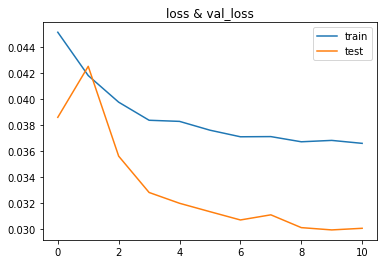

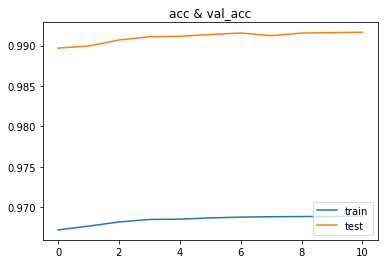

In [21]:
import os
import numpy as np
import pandas as pd
from data_helper import predict_15k, save_hist, save_model

### Save history
save_hist(History1, outPath)
### Save model
#save_model(model_ex1, outPath)
# Retain best model
#from keras import models
#model_ex1 = models.load_model(outPath + "weights.hdf5")

## Independent Test

15k Example: 
accuracy: 0.9764130991339968
IoU: 0.885579034522481
accuracy: 0.9843221618357488
IoU: 0.9237434372361126
15k Example: 
accuracy: 0.982896331738437
IoU: 0.9261015173858516
accuracy: 0.9867433054177006
IoU: 0.9426947303733292


,Input vs Target (Test1),Prediction vs Target (Test1),Input vs Target (Test2),Prediction vs Target (Test2)
Metrics,,,,
Accuracy,0.976413,0.984322,0.982896,0.986743
IoU,0.885579,0.923743,0.926102,0.942695


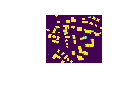

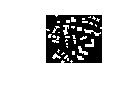

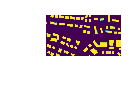

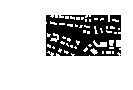

In [22]:
testPath = r"../tmp_data/Data/Testing/"

all_records = []

records = predict_15k(outPath, testPath, outPath, 
                      r"FTest1_input_inv.png", r"FTest1_output_inv.png")
all_records.extend(records)

records = predict_15k(outPath, testPath, outPath, 
                      r"FTest2_input_inv.png", r"FTest2_output_inv.png")
all_records.extend(records)

df = pd.DataFrame(np.transpose(all_records))
df.columns = ["Input vs Target (Test1)", "Prediction vs Target (Test1)", 
              "Input vs Target (Test2)", "Prediction vs Target (Test2)"]

df = df.rename({0: "Accuracy", 1: 'IoU'})
df.index.name = 'Metrics'
df